In [1]:
import logging
import os
from pprint import pprint

import dask.dataframe as dd
import numpy as np
import pandas as pd
import scipy.stats
from cloudpathlib import AnyPath as Path

import helpers

In [74]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
handler = logging.StreamHandler()
formatter = logging.Formatter(
    "%(asctime)s %(process)d/%(threadName)s %(name)s %(levelname)s\n%(message)s"
)
handler.setFormatter(formatter)
logging.getLogger().handlers = [handler]

In [3]:
logging.getLogger("gcsfs").setLevel("DEBUG")
logging.getLogger("google.cloud.bigquery").setLevel("DEBUG")
logging.getLogger("helpers").setLevel("DEBUG")
logging.getLogger("pandas").setLevel("DEBUG")
logging.getLogger("pyarrow").setLevel("DEBUG")

In [4]:
logger = logging.getLogger(__name__)
logger.setLevel("DEBUG")
logger.debug("test debug-level message")

2022-07-07 13:19:43,699 79180/MainThread __main__ DEBUG
test debug-level message


### TCGA SKCM (real) bulk rna-seq

In [5]:
uri_tcga_skcm_bulk_rnaseq = (
    "gs://liulab/data/pseudobulk_optimization/3_with_tcga_qc/"
    "mixtures_real_tcga_skcm/tpm.parquet"
)

In [6]:
!gsutil ls -lh $uri_tcga_skcm_bulk_rnaseq

 45.23 MiB  2022-05-26T05:32:00Z  gs://liulab/data/pseudobulk_optimization/3_with_tcga_qc/mixtures_real_tcga_skcm/tpm.parquet
TOTAL: 1 objects, 47427179 bytes (45.23 MiB)


In [7]:
ddf_tcga_skcm_bulk_rnaseq = dd.read_parquet(uri_tcga_skcm_bulk_rnaseq, engine="pyarrow")
logger.debug(ddf_tcga_skcm_bulk_rnaseq.dtypes)

2022-07-07 13:19:45,384 79180/MainThread gcsfs.credentials DEBUG
Connected with method google_default
2022-07-07 13:19:45,387 79180/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'data/pseudobulk_optimization/3_with_tcga_qc/mixtures_real_tcga_skcm/tpm.parquet'), None
2022-07-07 13:19:45,388 79180/fsspecIO gcsfs.credentials DEBUG
GCS refresh
2022-07-07 13:19:45,828 79180/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'data/pseudobulk_optimization/3_with_tcga_qc/mixtures_real_tcga_skcm/tpm.parquet'), None
2022-07-07 13:19:45,970 79180/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'data/pseudobulk_optimization/3_with_tcga_qc/mixtures_real_tcga_skcm/tpm.parquet'), None
2022-07-07 13:19:46,111 79180/fsspecIO gcsfs DEBUG
GET: https://storage.googleapis.com/download/storage/v1/b/liulab/o/data%2Fpseudobulk_optimization%2F3_with_tcga_qc%2Fmixtures_real_tcga_skcm%2Ftpm.parquet?alt=media, (), {'Range': 'bytes=47361643-47427178'}
2022-07-07 13:19:46,313 79180/fsspecIO gcsfs DEBUG
GET: b/{}/o/{

### pseudo bulk rna-seq

In [9]:
uri_pseudobulk_rnaseq = (
    "gs://liulab/data/pseudobulk_optimization/3_with_tcga_qc/"
    "mixtures/n_cells=5/malignant_from_one_sample=True/data.parquet"
)

In [10]:
!gsutil ls -lh $uri_pseudobulk_rnaseq

 39.95 MiB  2022-05-26T05:33:49Z  gs://liulab/data/pseudobulk_optimization/3_with_tcga_qc/mixtures/n_cells=5/malignant_from_one_sample=True/data.parquet
TOTAL: 1 objects, 41894774 bytes (39.95 MiB)


In [16]:
ddf_pseudobulk_rnaseq = (
    dd.read_parquet(
        uri_pseudobulk_rnaseq,
        engine="pyarrow",
    )
    .replace({"malignant_from_one_sample": {"True": True, "False": False}})
    .astype({"n_cells": "uint8", "malignant_from_one_sample": "bool"})
    .rename(columns={"tcga_aliquot_barcode_for_fractions": "aliquot_barcode"})
)

logger.debug(ddf_pseudobulk_rnaseq.dtypes)

2022-07-07 13:32:07,370 79180/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'data/pseudobulk_optimization/3_with_tcga_qc/mixtures/n_cells=5/malignant_from_one_sample=True/data.parquet'), None
2022-07-07 13:32:07,601 79180/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'data/pseudobulk_optimization/3_with_tcga_qc/mixtures/n_cells=5/malignant_from_one_sample=True/data.parquet'), None
2022-07-07 13:32:07,763 79180/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'data/pseudobulk_optimization/3_with_tcga_qc/mixtures/n_cells=5/malignant_from_one_sample=True/data.parquet'), None
2022-07-07 13:32:07,905 79180/fsspecIO gcsfs DEBUG
GET: https://storage.googleapis.com/download/storage/v1/b/liulab/o/data%2Fpseudobulk_optimization%2F3_with_tcga_qc%2Fmixtures%2Fn_cells=5%2Fmalignant_from_one_sample=True%2Fdata.parquet?alt=media, (), {'Range': 'bytes=41829238-41894773'}
2022-07-07 13:32:08,100 79180/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'data/pseudobulk_optimization/3_with_tcga_qc/mixtur

### analysis

In [17]:
# merge real and pseudo data
ddf_bulk_rnaseq_all = ddf_tcga_skcm_bulk_rnaseq.merge(
    ddf_pseudobulk_rnaseq,
    on=["aliquot_barcode", "gene_symbol"],
    how="inner",
    suffixes=["_tcga_skcm", "_pseudo"],
)

In [18]:
ddf_bulk_rnaseq_all

,gene_symbol,aliquot_barcode,tpm_tcga_skcm,tpm_pseudo,n_cells,malignant_from_one_sample
npartitions=1,,,,,,
,category[unknown],category[unknown],float64,float64,uint8,bool
,...,...,...,...,...,...


#### determine immune high and low

In [19]:
# load cell type fractions
df_tcga_skcm_fractions_from_csx = helpers.datasets.load_tcga_skcm_fractions_from_csx()

2022-07-07 13:32:46,201 79180/MainThread helpers.datasets DEBUG
loading TCGA SKCM fractions estimated by CIBERSORTx
2022-07-07 13:32:46,205 79180/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'downloaded_manually/derek_csx_tcga_skcm/CIBERSORTx_Job8_Results.txt'), None
2022-07-07 13:32:46,449 79180/fsspecIO gcsfs DEBUG
GET: https://storage.googleapis.com/download/storage/v1/b/liulab/o/downloaded_manually%2Fderek_csx_tcga_skcm%2FCIBERSORTx_Job8_Results.txt?alt=media, (), {'Range': 'bytes=0-86860'}


In [33]:
# create immune fraction value for each sample
immune_cell_types = ["B", "Macrophage", "NK", "T", "T CD4", "T CD8"]

df_immune_fraction_by_aliquot_barcode = (
    df_tcga_skcm_fractions_from_csx[immune_cell_types]
    .sum(axis="columns")
    .rename("immune_fraction")
    .to_frame()
)

In [34]:
df_immune_fraction_by_aliquot_barcode

,immune_fraction
sample_id,
TCGA-3N-A9WB-06A-11R-A38C-07,0.006247
TCGA-3N-A9WC-06A-11R-A38C-07,0.269736
TCGA-3N-A9WD-06A-11R-A38C-07,0.119879
TCGA-BF-A1PU-01A-11R-A18S-07,0.023436
TCGA-BF-A1PV-01A-11R-A18U-07,0.013171
...,...
TCGA-YG-AA3O-06A-11R-A38C-07,0.042878
TCGA-YG-AA3P-06A-11R-A38C-07,0.027623
TCGA-Z2-A8RT-06A-11R-A37K-07,0.092170


In [39]:
# join these fractions onto bulk rna-seq data

ddf_bulk_rnaseq_all_with_immune = ddf_bulk_rnaseq_all.merge(
    df_immune_fraction_by_aliquot_barcode,
    left_on="aliquot_barcode",
    right_on="sample_id",
)

ddf_bulk_rnaseq_all_with_immune

,gene_symbol,aliquot_barcode,tpm_tcga_skcm,tpm_pseudo,n_cells,malignant_from_one_sample,immune_fraction
npartitions=1,,,,,,,
,category[unknown],object,float64,float64,uint8,bool,float64
,...,...,...,...,...,...,...


In [46]:
# compute immune high and low
immune_threshold_low = ddf_bulk_rnaseq_all_with_immune["immune_fraction"].quantile(0.2)
immune_threshold_high = ddf_bulk_rnaseq_all_with_immune["immune_fraction"].quantile(0.8)

In [47]:
immune_threshold_low, immune_threshold_hi

(dd.Scalar<quantil..., dtype=float64>, dd.Scalar<quantil..., dtype=float64>)

In [48]:
ddf_bulk_rnaseq_all_with_immune["immune_low"] = (
    ddf_bulk_rnaseq_all_with_immune["immune_fraction"] <= immune_threshold_low
)

ddf_bulk_rnaseq_all_with_immune["immune_high"] = (
    ddf_bulk_rnaseq_all_with_immune["immune_fraction"] >= immune_threshold_high
)

In [50]:
df_bulk_rnaseq_all_with_immune = ddf_bulk_rnaseq_all_with_immune.compute()

2022-07-07 13:47:05,927 79180/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'data/pseudobulk_optimization/3_with_tcga_qc/mixtures/n_cells=5/malignant_from_one_sample=True/data.parquet'), None
2022-07-07 13:47:05,929 79180/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'data/pseudobulk_optimization/3_with_tcga_qc/mixtures_real_tcga_skcm/tpm.parquet'), None
2022-07-07 13:47:06,185 79180/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'data/pseudobulk_optimization/3_with_tcga_qc/mixtures/n_cells=5/malignant_from_one_sample=True/data.parquet'), None
2022-07-07 13:47:06,192 79180/fsspecIO gcsfs DEBUG
GET: https://storage.googleapis.com/download/storage/v1/b/liulab/o/data%2Fpseudobulk_optimization%2F3_with_tcga_qc%2Fmixtures_real_tcga_skcm%2Ftpm.parquet?alt=media, (), {'Range': 'bytes=47361643-47427178'}
2022-07-07 13:47:06,328 79180/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'data/pseudobulk_optimization/3_with_tcga_qc/mixtures/n_cells=5/malignant_from_one_sample=True/data.parquet')

In [53]:
df_bulk_rnaseq_all_with_immune["aliquot_barcode"].value_counts()

TCGA-3N-A9WB-06A-11R-A38C-07    16063
TCGA-ER-A2NF-06A-11R-A18T-07    16063
TCGA-FR-A3YN-06A-11R-A239-07    16063
TCGA-ER-A42L-06A-11R-A24X-07    16063
TCGA-ER-A42K-06A-11R-A24X-07    16063
                                ...  
TCGA-EE-A17X-06A-11R-A18S-07    16063
TCGA-EB-A6L9-06A-11R-A32P-07    16063
TCGA-EB-A5VV-06A-11R-A32P-07    16063
TCGA-EB-A5UN-06A-11R-A311-07    16063
TCGA-Z2-AA3V-06A-11R-A39D-07    16063
Name: aliquot_barcode, Length: 368, dtype: int64

In [52]:
df_bulk_rnaseq_all_with_immune[["immune_low", "immune_high"]].value_counts()

immune_low  immune_high
False       False          3533860
            True           1188662
True        False          1188662
dtype: int64

In [87]:
### compute p-values...


def compute_stats(df):
    immune_low = df[df["immune_low"]]
    immune_high = df[df["immune_high"]]
    pval_pseudo = scipy.stats.mannwhitneyu(
        immune_high["tpm_pseudo"].values, immune_low["tpm_pseudo"].values
    )[1]
    neglogpval_pseudo = -np.log(pval_pseudo)
    foldchange_pseudo = (
        immune_high["tpm_pseudo"].mean() / immune_low["tpm_pseudo"].mean()
    )
    log2foldchange_pseudo = np.log2(foldchange_pseudo)

    pval_real = scipy.stats.mannwhitneyu(
        immune_high["tpm_tcga_skcm"].values, immune_low["tpm_tcga_skcm"].values
    )[1]
    neglogpval_real = -np.log(pval_real)
    foldchange_real = (
        immune_high["tpm_tcga_skcm"].mean() / immune_low["tpm_tcga_skcm"].mean()
    )
    log2foldchange_real = np.log2(foldchange_real)

    return pd.Series(
        dict(
            pval_pseudo=pval_pseudo,
            foldchange_pseudo=foldchange_pseudo,
            log2foldchange_pseudo=log2foldchange_pseudo,
            neglogpval_pseudo=neglogpval_pseudo,
            signedneglogpval_pseudo=(
                neglogpval_pseudo * np.sign(log2foldchange_pseudo)
            ),
            pval_real=pval_real,
            foldchange_real=foldchange_real,
            log2foldchange_real=log2foldchange_real,
            neglogpval_real=neglogpval_real,
            signedneglogpval_real=(neglogpval_real * np.sign(log2foldchange_real)),
        )
    )


df_gene_stats_by_immune = df_bulk_rnaseq_all_with_immune.groupby("gene_symbol").apply(
    compute_stats
)

In [88]:
df_gene_stats_by_immune

,pval_pseudo,foldchange_pseudo,log2foldchange_pseudo,neglogpval_pseudo,signedneglogpval_pseudo,pval_real,foldchange_real,log2foldchange_real,neglogpval_real,signedneglogpval_real
gene_symbol,,,,,,,,,,
A1BG,6.412492e-01,0.720147,-0.473636,0.444337,-0.444337,2.760504e-03,0.749164,-0.416646,5.892342,-5.892342
A2M,3.167108e-03,1.271063,0.346036,5.754936,5.754936,2.658208e-03,1.324988,0.405979,5.930103,5.930103
A2ML1,4.388290e-08,1.814381,0.859477,16.941741,16.941741,7.338630e-02,2.437467,1.285382,2.612018,2.612018
A4GALT,3.338668e-07,2.891020,1.531578,14.912524,14.912524,1.673329e-09,2.291428,1.196247,20.208451,20.208451
A4GNT,1.105002e-01,0.711084,-0.491909,2.202738,-2.202738,5.205548e-01,1.056338,0.079072,0.652860,0.652860
...,...,...,...,...,...,...,...,...,...,...
ZYG11A,9.151915e-13,1.830013,0.871854,27.719643,27.719643,1.032366e-06,1.179268,0.237892,13.783657,13.783657
ZYG11B,2.335214e-04,1.296229,0.374321,8.362237,8.362237,2.216201e-02,0.852496,-0.230235,3.809376,-3.809376
ZYX,2.012901e-10,1.778343,0.830534,22.326274,22.326274,1.142813e-09,1.302782,0.381596,20.589774,20.589774


In [104]:
# how many genes have valid stats?

logger.debug(df_gene_stats_by_immune["pval_pseudo"].isna().value_counts())
logger.debug(df_gene_stats_by_immune["foldchange_pseudo"].isna().value_counts())
logger.debug(df_gene_stats_by_immune["pval_real"].isna().value_counts())
logger.debug(df_gene_stats_by_immune["foldchange_real"].isna().value_counts())

2022-07-07 15:06:02,621 79180/MainThread __main__ DEBUG
False    16063
Name: pval_pseudo, dtype: int64
2022-07-07 15:06:02,625 79180/MainThread __main__ DEBUG
False    16054
True         9
Name: foldchange_pseudo, dtype: int64
2022-07-07 15:06:02,628 79180/MainThread __main__ DEBUG
False    16063
Name: pval_real, dtype: int64
2022-07-07 15:06:02,632 79180/MainThread __main__ DEBUG
False    16063
Name: foldchange_real, dtype: int64


In [89]:
import plotly.express as px

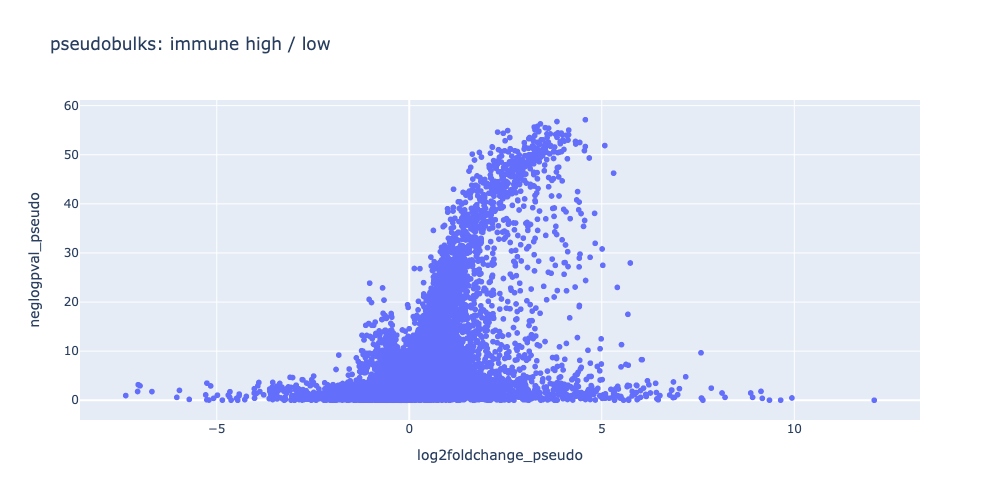

In [106]:
fig = px.scatter(
    df_gene_stats_by_immune,
    x="log2foldchange_pseudo",
    y="neglogpval_pseudo",
    title="pseudobulks: immune high / low",
)
fig.show(renderer="png", scale=1, width=1000, height=500)

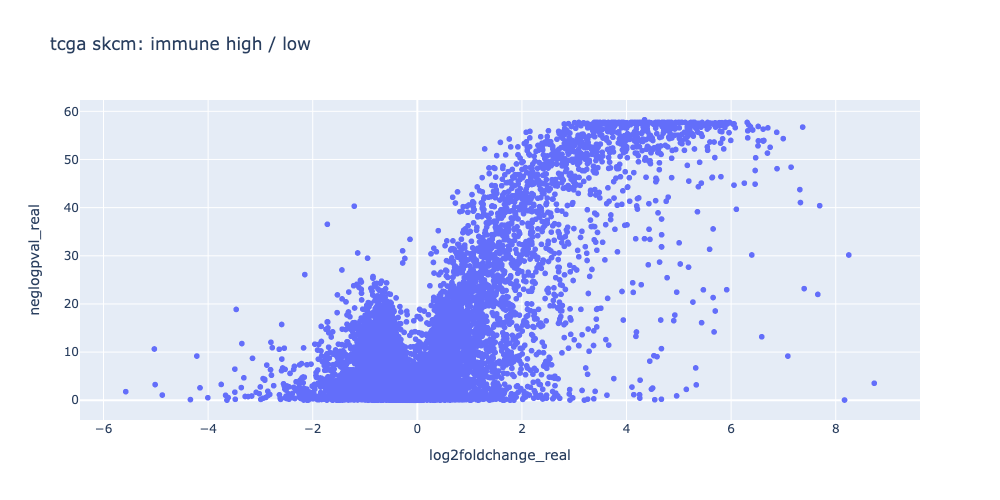

In [107]:
fig = px.scatter(
    df_gene_stats_by_immune,
    x="log2foldchange_real",
    y="neglogpval_real",
    title="tcga skcm: immune high / low",
)
fig.show(renderer="png", scale=1, width=1000, height=500)

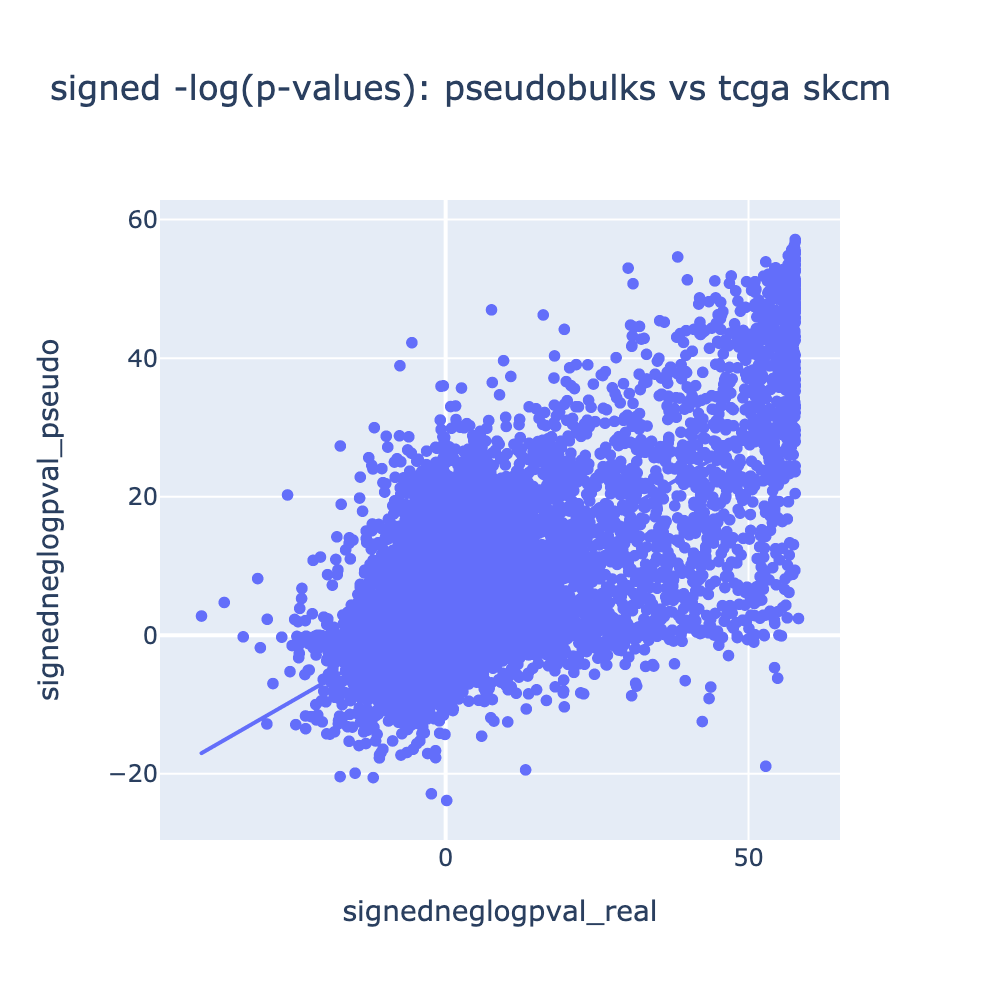

In [113]:
fig = px.scatter(
    df_gene_stats_by_immune,
    x="signedneglogpval_real",
    y="signedneglogpval_pseudo",
    trendline="ols",
    title="signed -log(p-values): pseudobulks vs tcga skcm",
)
fig.show(renderer="png", scale=2, width=500, height=500)